In [31]:
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://huggingface.co/blog/fine-tune-vit
# https://huggingface.co/google/vit-base-patch16-224-in21k
# ViT model: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py#L37

Size of data_coins 112 : Size of labels_coins 112
Size of data_others 112 : Size of labels_others 112


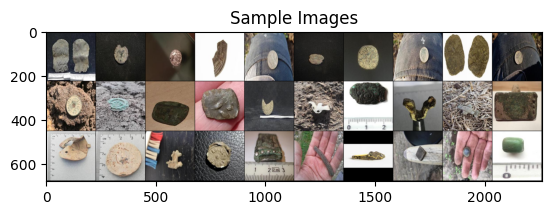

In [1]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from PIL import Image

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images

path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/coins-2023 224x224/coins"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/other-2023 224x224/other"


# path_to_coins = "/mnt/c/Users/bucha/Pictures/coins_224x224"
# path_to_others = "/mnt/c/Users/bucha/Pictures/other_224x224"


def load_data_from_directory_with_limit(directory_path, label, limit=10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label=1, limit=2500)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label=0, limit=2500)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images = 30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow = 10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images=num_images_to_display_per_category * 2)

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p=.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors=(coin_dataT, coin_labelsT), transform=imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors=(other_dataT, other_labelsT), transform=imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size - GPU may be overloaded with memory allocations if too high
BATCH_SIZE = 4
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size=BATCH_SIZE, shuffle=False) # For test -> below cell
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 156 : Each batch size 39
Total number of elements in val_loader: 36 : Each batch size 9
Total number of elements in test_loader: 36 : Each batch size 9


In [3]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW
import torch

model_name_or_path = 'google/vit-base-patch16-224-in21k'
vit_model = ViTForImageClassification.from_pretrained(model_name_or_path)
vit_model.size = {"height": 256, "width": 256}

# Model configs
print(vit_model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

Epoch 1/10 - Time: 5.5497s - Test Loss: 0.66928843 - Test Accuracy: 0.68571429 - Test Precision: 0.73333333 - Test Recall: 0.61111111 - Test F1 Score: 0.66666667
Epoch 2/10 - Time: 5.4462s - Test Loss: 0.66684857 - Test Accuracy: 0.67142857 - Test Precision: 0.70967742 - Test Recall: 0.61111111 - Test F1 Score: 0.65671642
Epoch 3/10 - Time: 5.4699s - Test Loss: 0.65411080 - Test Accuracy: 0.68571429 - Test Precision: 0.73333333 - Test Recall: 0.61111111 - Test F1 Score: 0.66666667
Epoch 4/10 - Time: 5.4173s - Test Loss: 0.64822737 - Test Accuracy: 0.70714286 - Test Precision: 0.75409836 - Test Recall: 0.63888889 - Test F1 Score: 0.69172932
Epoch 5/10 - Time: 5.3947s - Test Loss: 0.63831651 - Test Accuracy: 0.71428571 - Test Precision: 0.75641026 - Test Recall: 0.65555556 - Test F1 Score: 0.70238095
Epoch 6/10 - Time: 5.4642s - Test Loss: 0.64257719 - Test Accuracy: 0.71904762 - Test Precision: 0.75789474 - Test Recall: 0.66666667 - Test F1 Score: 0.70935961
Epoch 7/10 - Time: 5.4770s -

ValueError: x and y must have same first dimension, but have shapes (10,) and (90,)

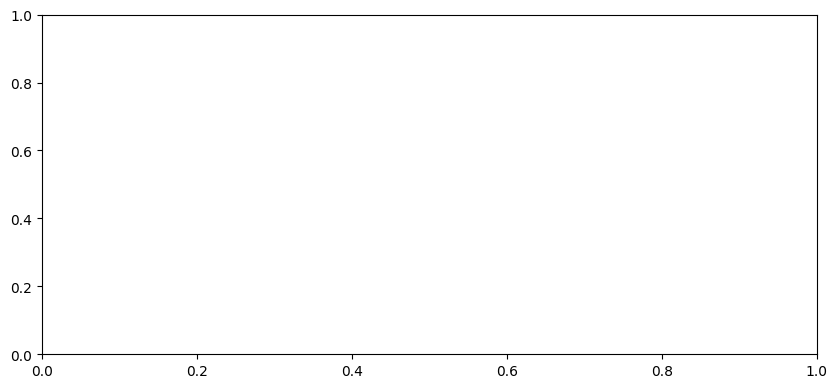

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import time 
import seaborn as sns

optimizer = torch.optim.AdamW(vit_model.parameters(), lr = 1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
threshold = 0.5

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model.to(device)

all_val_preds = []
all_val_labels = []
all_test_preds = []
all_test_labels = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_auc_rocs = []
test_conf_matrices = []

test_loss
test_accuracy
test_precision
test_recall
test_f1
test_roc_auc

def get_prediction(predictions):
    largest_values = []
    sigmoid_values = []

    for preds in predictions:
        # Get the largest values in prediction
        largest_values.append(torch.max(preds))

    for values in largest_values:
        # Applying sigmoid to the largest value
        sigmoid_values.append(torch.sigmoid(values))

    # Convert sigmoid_values to a tensor
    sigmoid_tensor = torch.stack(sigmoid_values)
    sigmoid_tensor = sigmoid_tensor.view(-1, 1) # Reshape tensor to fir the labels tensor

    return sigmoid_tensor    
    
# RUN

total_time_start = time.time()  # Record the start time
for epoch in range(num_epochs):
    epoch_time_start = time.time()
    vit_model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(inputs)
        prediction = get_prediction(outputs.logits)
        loss = criterion(prediction, labels.float())
        loss.backward()
        optimizer.step()

    vit_model.eval()

    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
     
            outputs = vit_model(inputs)
            prediction = get_prediction(outputs.logits) 
            val_loss = criterion(prediction, labels.float())
            total_val_loss += val_loss.item()

    total_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device) # CPU or GPU
     
            outputs = vit_model(inputs)
            prediction = get_prediction(outputs.logits) 
            test_loss = criterion(prediction, labels.float())
            total_test_loss += test_loss.item()

            preds = (prediction > threshold).int()  # Threshold is used to determine the predicted value - 0 or 1 based on the threshold value
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())


            # Calculate AUC-ROC
            fpr, tpr, _ = roc_curve(all_test_labels, all_test_preds)
            test_roc_auc = auc(fpr, tpr)
            # Create confusion matrix
            conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
        
            # https://scikit-learn.org/stable/modules/model_evaluation.html
            test_loss = total_test_loss / len(test_loader)
            test_accuracy = accuracy_score(
                all_test_labels,
                all_test_preds
            )
            test_precision = precision_score(
                all_test_labels,
                all_test_preds,
                zero_division=0,
                average='binary'
            )
            test_recall = recall_score(
                all_test_labels,
                all_test_preds
            )
            test_f1 = f1_score(
                all_test_labels,
                all_test_preds
            )

            # Create confusion matrix
            test_conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

            test_conf_matrices.append(test_conf_matrix)
            
    
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            test_precisions.append(test_precision)
            test_recalls.append(test_recall)
            test_f1_scores.append(test_f1)
            test_auc_rocs.append(test_roc_auc)
    
            test_conf_matrices.append(test_conf_matrix)

        # Calculate and print the time taken for the epoch
        epoch_time_end = time.time()
        epoch_time_elapsed = epoch_time_end - epoch_time_start

        # Testing prints
        print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time_elapsed:.4f}s - '
              f'Test Loss: {test_loss:.8f} - '
              f'Test Accuracy: {test_accuracy:.8f} - '
              f'Test Precision: {test_precision:.8f} - '
              f'Test Recall: {test_recall:.8f} - '
              f'Test F1 Score: {test_f1:.8f}')

            
# Calculate and print the total time taken
total_time_end = time.time()
total_time_elapsed = total_time_end - total_time_start
print(f'Total Training Time: {total_time_elapsed:.4f}s')        
    
# Plotting
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 15))  # Adjust the figure size accordingly

# Plot Accuracy, Precision, Recall, F1 Score, and AUC-ROC for Test
plt.subplot(3, 1, 1)  # Five rows, one column, third subplot
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.plot(epochs, test_precisions, label='Test Precision')
plt.plot(epochs, test_recalls, label='Test Recall')
plt.plot(epochs, test_f1_scores, label='Test F1 Score')
plt.plot(epochs, test_auc_rocs, label='Test AUC-ROC')
plt.title('Test Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Plot Testing Loss
plt.subplot(3, 1, 2)  # Five rows, one column, fourth subplot
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Confusion Matrices for each epoch
plt.subplot(3, 1, 3)  # Five rows, one column, fifth subplot
all_conf_matrices = np.stack(test_conf_matrices, axis=0)
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)  # Calculate the average confusion matrix
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()